In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from kneebow.rotor import Rotor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import os
import re

## Funciones auxiliares

In [2]:
#We calculate or k-distance for determinate our eps value.
def calculate_kn_distance(X, neigh=2):
    neigh = NearestNeighbors(n_neighbors=neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances[:,1:].reshape(-1)

#We get the eps exact value using kneebow, this function allows
#us to find the elbow of a curve by rotating the curve and taking
#the minimum value.
def get_eps(X, neigh=2):
    eps_dist = np.sort(calculate_kn_distance(X, neigh=neigh))
    rotor = Rotor()
    curve_xy = np.concatenate([np.arange(eps_dist.shape[0]).reshape(-1, 1), eps_dist.reshape(-1, 1)],1)
    rotor.fit_rotate(curve_xy)
    rotor.plot_elbow()
    e_idx = rotor.get_elbow_index()
    return curve_xy[e_idx]

## carga de datos 

In [3]:
file_path="../data/interim/estadisticas_edificios.csv"

In [4]:
data = pd.read_csv(file_path)
data.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev
0,RefBldgFullServiceRestaurantNew2004,38.877634,13.139998,3.998243,1.490142,9.179851,2.960208
1,RefBldgFullServiceRestaurantNew2004,39.231781,13.459672,3.993560,1.488397,9.179851,2.960208
2,RefBldgFullServiceRestaurantNew2004,39.321435,13.945362,3.992549,1.488020,9.179851,2.960208
3,RefBldgFullServiceRestaurantNew2004,38.689354,12.083141,3.964785,1.477673,9.179851,2.960208
4,RefBldgFullServiceRestaurantNew2004,38.713755,12.127984,3.987958,1.486309,9.179851,2.960208


In [5]:
data.columns

Index(['type_building', 'var1_mean', 'var1_std_dev', 'var2_mean',
       'var2_std_dev', 'var3_mean', 'var3_std_dev'],
      dtype='object')

In [6]:
# Obtener un resumen estadístico y mostrar la información general del conjunto de datos
summary = data.describe()
summary

,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,180.856123,94.554094,17.007510,7.016523,21.508703,32.807023
std,274.716614,128.967601,23.647561,9.107792,24.725756,45.157198
min,6.033994,4.002892,0.968445,0.711591,0.550005,1.196898
25%,27.533792,17.795171,2.772062,1.416750,5.451126,6.810785
50%,62.731332,40.073529,6.960570,4.100985,11.914006,16.365310
75%,197.050593,81.871898,28.420933,6.633711,23.766720,28.749189
max,1066.621718,478.877942,96.689762,37.823520,100.150657,178.686652


In [7]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type_building  80 non-null     object 
 1   var1_mean      80 non-null     float64
 2   var1_std_dev   80 non-null     float64
 3   var2_mean      80 non-null     float64
 4   var2_std_dev   80 non-null     float64
 5   var3_mean      80 non-null     float64
 6   var3_std_dev   80 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.5+ KB


In [8]:
# Identificar valores faltantes
missing_values = data.isnull().sum()
missing_values

type_building    0
var1_mean        0
var1_std_dev     0
var2_mean        0
var2_std_dev     0
var3_mean        0
var3_std_dev     0
dtype: int64

In [9]:
# Seleccionar todas las columnas numéricas para la estandarización
numeric_columns = data.select_dtypes(include=['float64']).columns

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])

# Convertir de nuevo a un DataFrame para mantener la consistencia
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)
# Añadir la columna 'type_building' de nuevo
data_scaled_df['type_building'] = data['type_building']

# Mostrar los primeros registros del DataFrame estandarizado
data_scaled_df.head()


,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev,type_building
0,-0.520079,-0.635258,-0.553602,-0.610603,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004
1,-0.518781,-0.632764,-0.553802,-0.610796,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004
2,-0.518453,-0.628974,-0.553845,-0.610838,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004
3,-0.520768,-0.643505,-0.555026,-0.611981,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004
4,-0.520679,-0.643155,-0.554040,-0.611027,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004


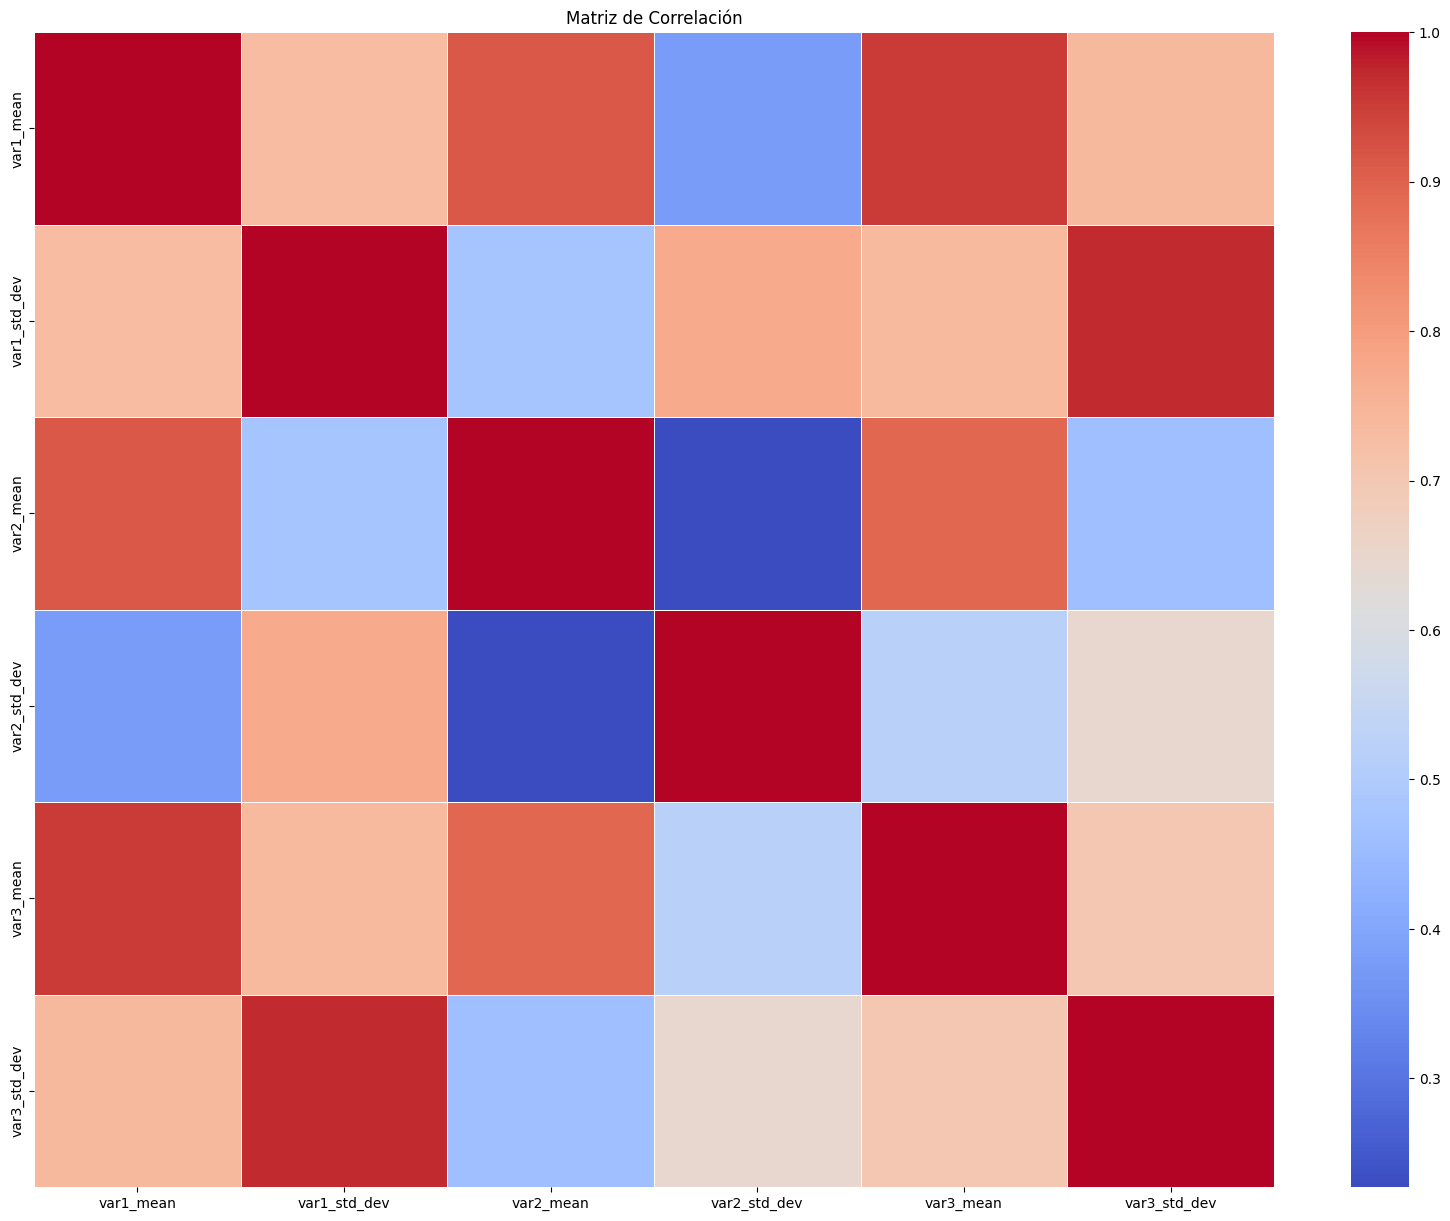

In [10]:
# Calcular la matriz de correlación
correlation_matrix = data_scaled_df.iloc[:,:-1].corr()

# Mostrar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [13]:
# Separar las características numéricas
features = data_scaled_df.drop(columns=['type_building']).copy()

In [15]:
features.iloc[:, :6]

,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev
0,-0.520079,-0.635258,-0.553602,-0.610603,-0.50177,-0.665124
1,-0.518781,-0.632764,-0.553802,-0.610796,-0.50177,-0.665124
2,-0.518453,-0.628974,-0.553845,-0.610838,-0.50177,-0.665124
3,-0.520768,-0.643505,-0.555026,-0.611981,-0.50177,-0.665124
4,-0.520679,-0.643155,-0.554040,-0.611027,-0.50177,-0.665124
...,...,...,...,...,...,...
75,-0.596218,-0.555694,-0.596336,-0.355793,-0.65230,-0.324028
76,-0.597526,-0.554518,-0.604796,-0.351189,-0.65230,-0.324028
77,-0.597555,-0.553678,-0.608739,-0.350331,-0.65230,-0.324028
78,-0.594574,-0.552416,-0.559752,-0.243828,-0.65230,-0.324028


[4.4814513  1.16151617 0.36406784 0.04558212 0.014646   0.00868595]


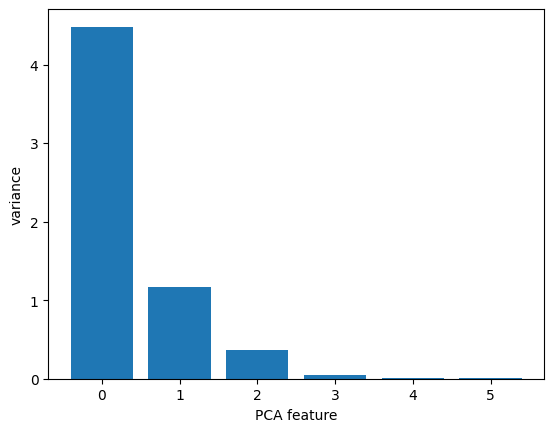

In [13]:
# Create a PCA instance: pca
pca = PCA()
# Fit the pipeline to 'samples'
pca.fit(features)
print(pca.explained_variance_)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

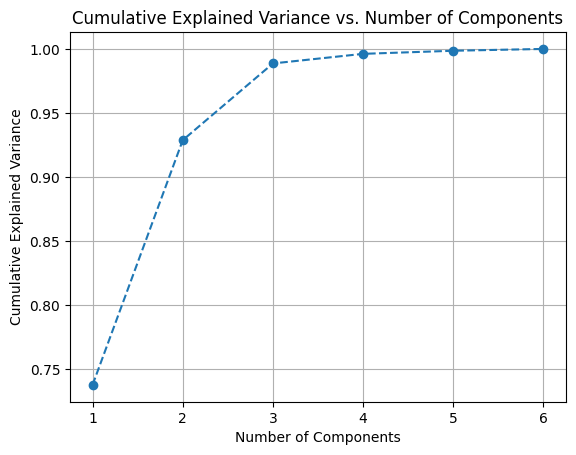

In [14]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [25]:
# Reducir la dimensionalidad utilizando PCA para seleccionar características no correlacionadas
# Separar las características numéricas
features = data_scaled_df.drop(columns=['type_building'])
pca = PCA(n_components=3)  # Seleccionamos un número razonable de componentes principales
principal_components = pca.fit_transform(features)

# Convertir a DataFrame para mantener la consistencia
principal_df =pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# # Añadir de nuevo la columna 'type_building'
# principal_df['type_building'] = data_reduced['type_building']

In [26]:
principal_df.head()

,PC1,PC2,PC3
0,-1.427405,-0.183470,-0.044311
1,-1.425934,-0.182994,-0.045361
2,-1.424236,-0.181754,-0.046478
3,-1.432092,-0.186200,-0.043228
4,-1.431256,-0.186089,-0.042464


In [27]:
# Paso 1: Examinar las Componentes Principales (PCA)
pca_loadings = pd.DataFrame(pca.components_.T, index=features.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_loadings

,PC1,PC2,PC3
var1_mean,0.430479,-0.313050,-0.151938
var1_std_dev,0.418370,0.354649,-0.271424
var2_mean,0.363370,-0.541493,0.219209
var2_std_dev,0.307385,0.575589,0.688556
var3_mean,0.436553,-0.237893,0.209781
var3_std_dev,0.404961,0.303742,-0.569877
Cluster_KMeans,0.241989,-0.053424,0.110971


Las cargas de las componentes principales (PCA) indican qué variables originales tienen mayor influencia en cada componente. Aquí están algunas observaciones clave:



## CLUSTERING 

### KMEANS

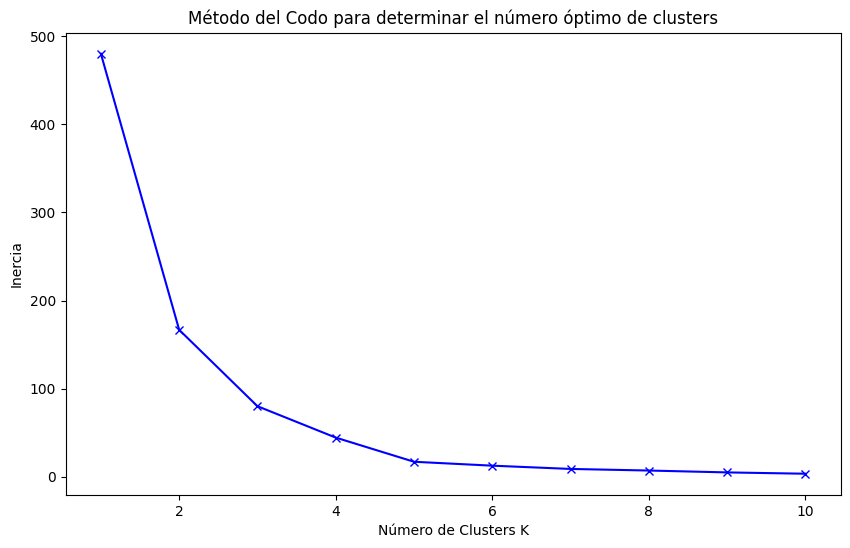

In [16]:
# Método del Codo para K-means
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features.iloc[:, :6])
    inertia.append(kmeans.inertia_)

# Gráfico del Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Número de Clusters K')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

In [17]:
# Calcular las diferencias entre inercias
inertia_differences = [j - i for i, j in zip(inertia[:-1], inertia[1:])]
# Imprimir las diferencias entre inercias
for i, diff in enumerate(inertia_differences, start=2):
    print(f"Diferencia de inercia entre {i-1} y {i} clusters: {diff}")

Diferencia de inercia entre 1 y 2 clusters: -313.1956493952831
Diferencia de inercia entre 2 y 3 clusters: -86.64971698983048
Diferencia de inercia entre 3 y 4 clusters: -35.60564282728999
Diferencia de inercia entre 4 y 5 clusters: -27.417476929717825
Diferencia de inercia entre 5 y 6 clusters: -4.434123258183124
Diferencia de inercia entre 6 y 7 clusters: -3.7072939644683576
Diferencia de inercia entre 7 y 8 clusters: -1.8122144457963074
Diferencia de inercia entre 8 y 9 clusters: -2.1252552934910414
Diferencia de inercia entre 9 y 10 clusters: -1.4864499514548744


basandonos en la grafica de los cambios de inercia  utilizamos el metodo del codo para determinar el numero optimo de clusters a agrupar estan entre 2 a 3

In [20]:
# Aplicar K-means con un número de clusters razonable, por ejemplo, 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(features.iloc[:, :6])

# Agregar los clusters al DataFrame para análisis posterior
data_scaled_df['Cluster_KMeans'] = clusters_kmeans
# Mostrar los primeros registros con los clusters asignados
data_scaled_df.head()

,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev,type_building,Cluster_KMeans
0,-0.520079,-0.635258,-0.553602,-0.610603,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0
1,-0.518781,-0.632764,-0.553802,-0.610796,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0
2,-0.518453,-0.628974,-0.553845,-0.610838,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0
3,-0.520768,-0.643505,-0.555026,-0.611981,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0
4,-0.520679,-0.643155,-0.554040,-0.611027,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [21]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_kmeans = silhouette_score(features.iloc[:, :6], clusters_kmeans)
silhouette_kmeans

0.7828345719153665

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [22]:
# Calcular el índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(features.iloc[:, :6], clusters_kmeans)
davies_bouldin

0.49346602543038726

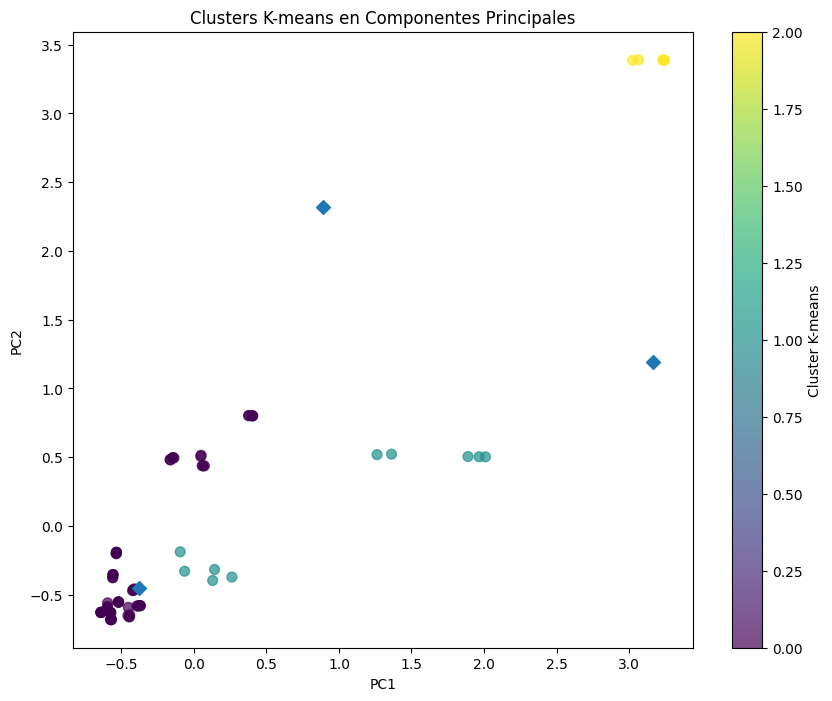

In [23]:
# Visualización de los clusters obtenidos por K-means
plt.figure(figsize=(10, 8))
plt.scatter(data_scaled_df['var1_mean'], data_scaled_df['var2_mean'], c=data_scaled_df['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters K-means en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster K-means')
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
"""
scatter plot of centroids_x and centroids_y, using 'D' (a diamond) as a marker by specifying the marker parameter. Set the size of the markers to be 50 using s=50.
"""
plt.scatter(centroids_x,centroids_y,marker="D",s=50)
plt.show()

In [25]:
# Create crosstab: ct
ct = pd.crosstab(data_scaled_df['type_building'] ,data_scaled_df['Cluster_KMeans'] )
# Display ct
ct

Cluster_KMeans,0,1,2
type_building,,,
RefBldgFullServiceRestaurantNew2004,5,0,0
RefBldgHospitalNew2004,0,0,5
RefBldgLargeHotelNew2004,5,0,0
RefBldgLargeOfficeNew2004,0,5,0
RefBldgMediumOfficeNew2004,5,0,0
RefBldgMidriseApartmentNew2004,5,0,0
RefBldgOutPatientNew2004,5,0,0
RefBldgPrimarySchoolNew2004,5,0,0
RefBldgQuickServiceRestaurantNew2004,5,0,0


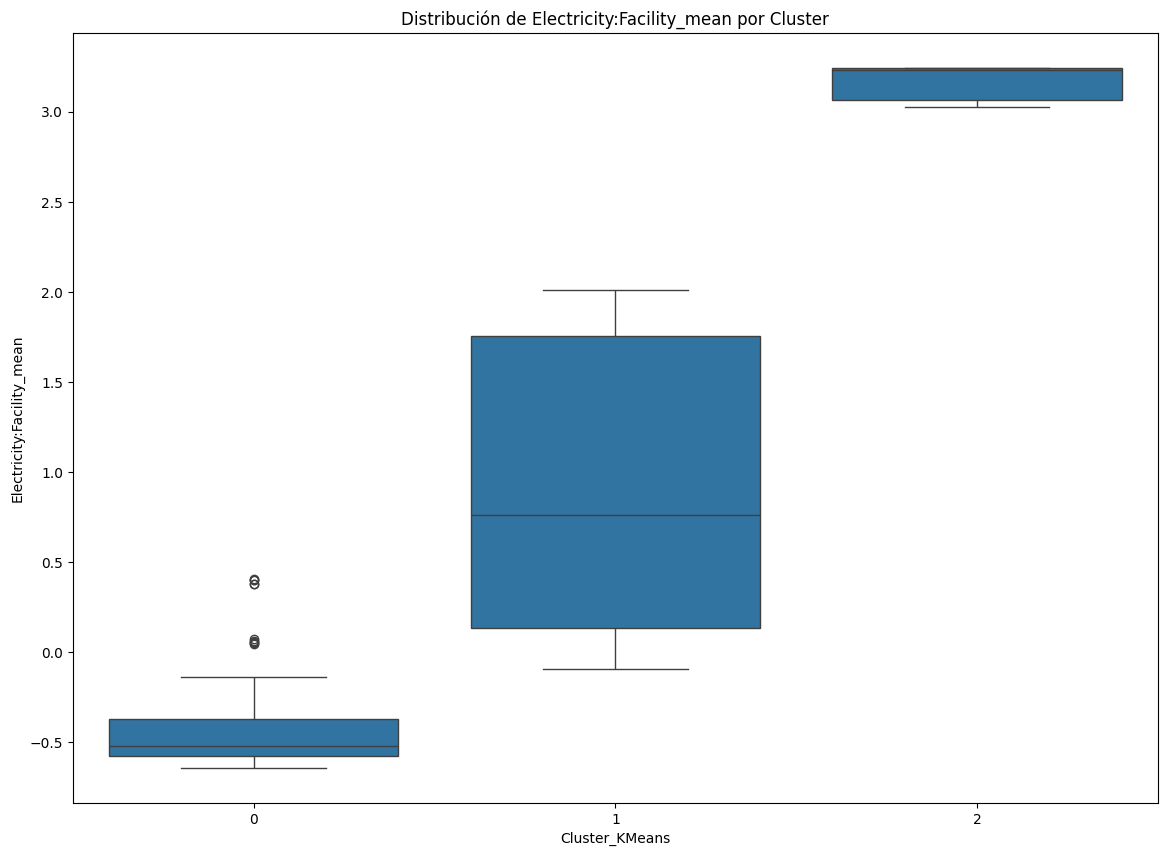

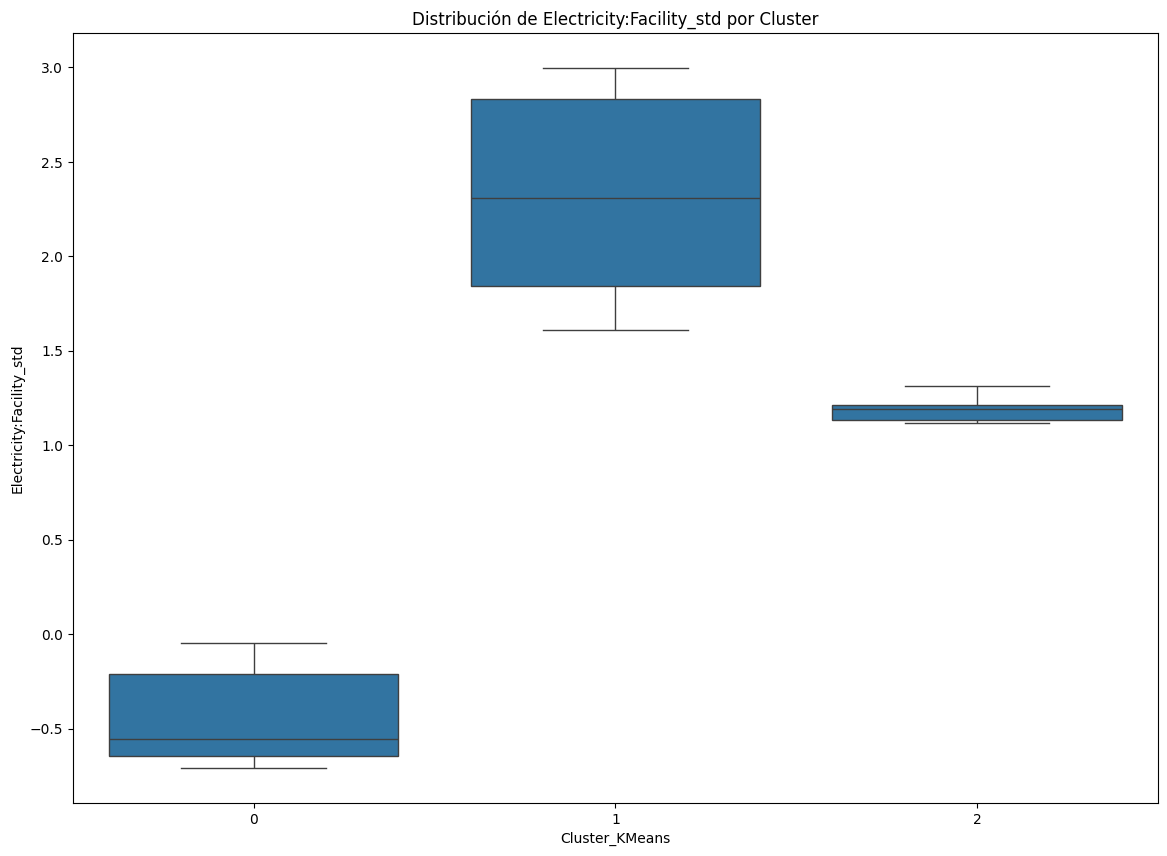

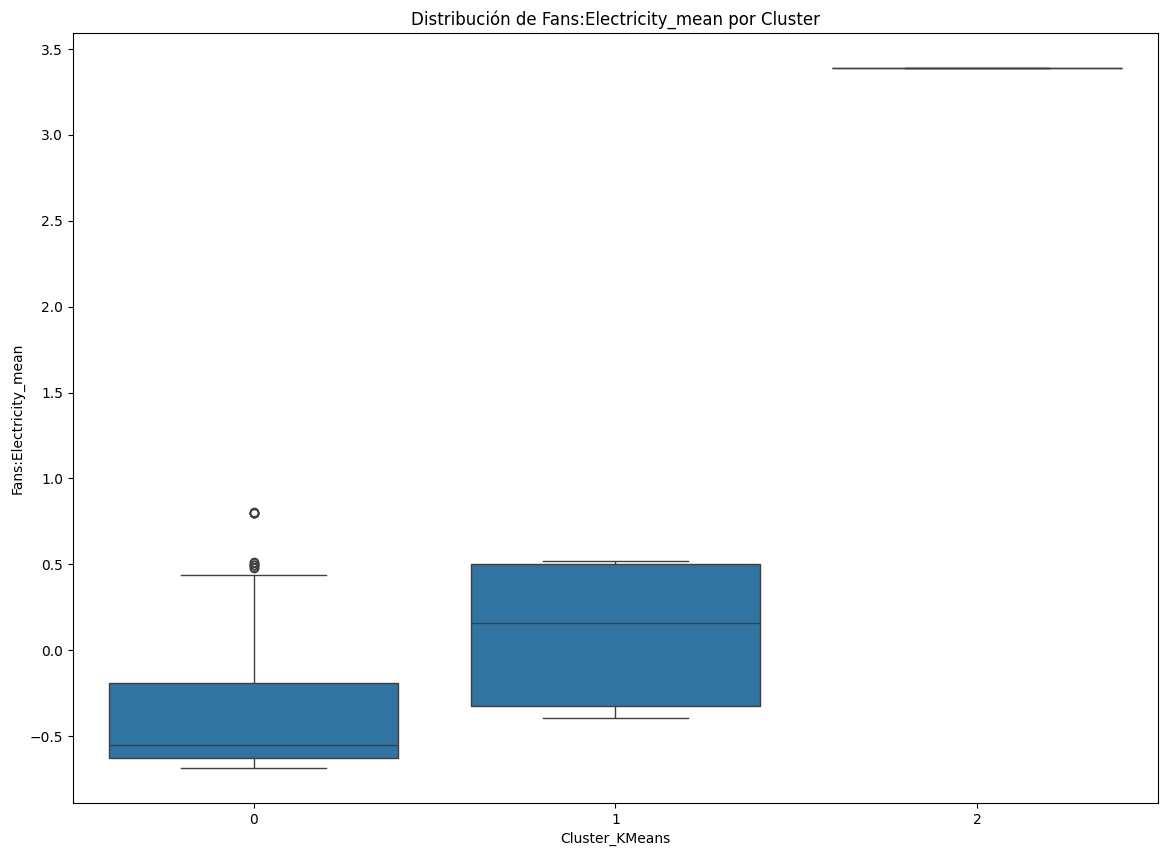

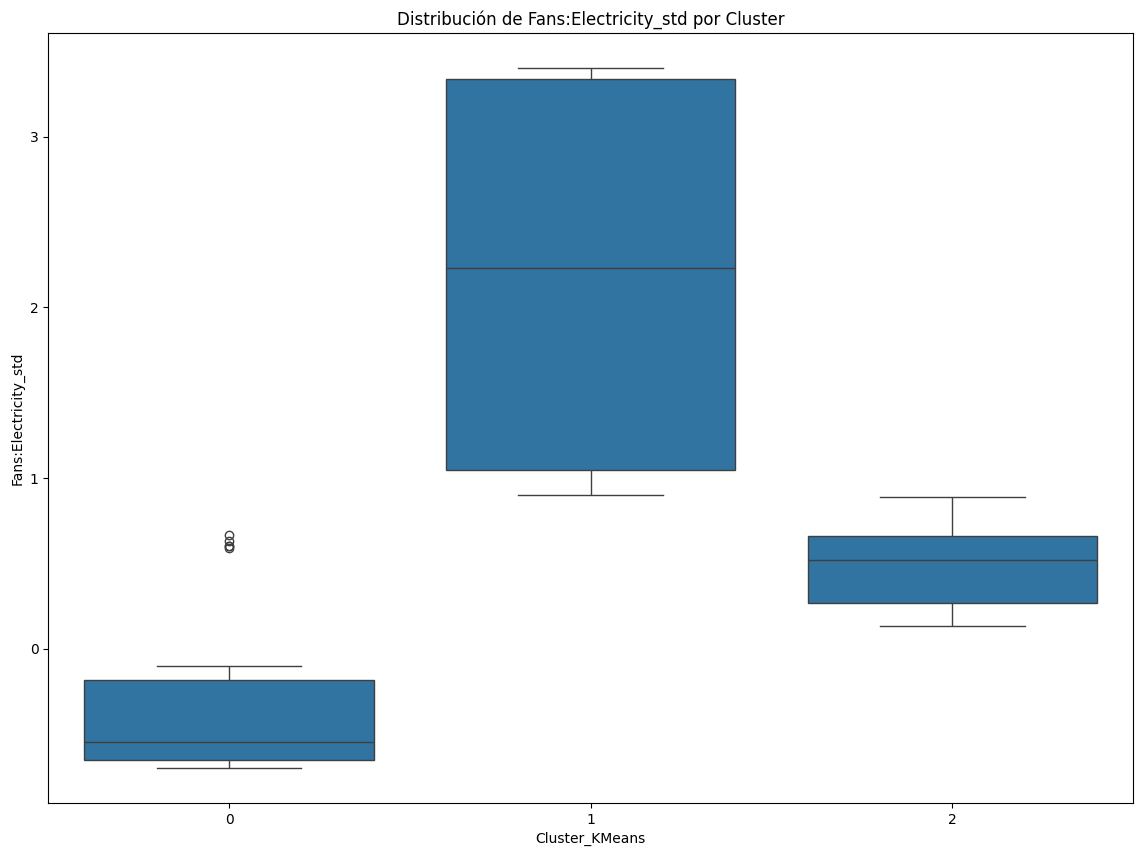

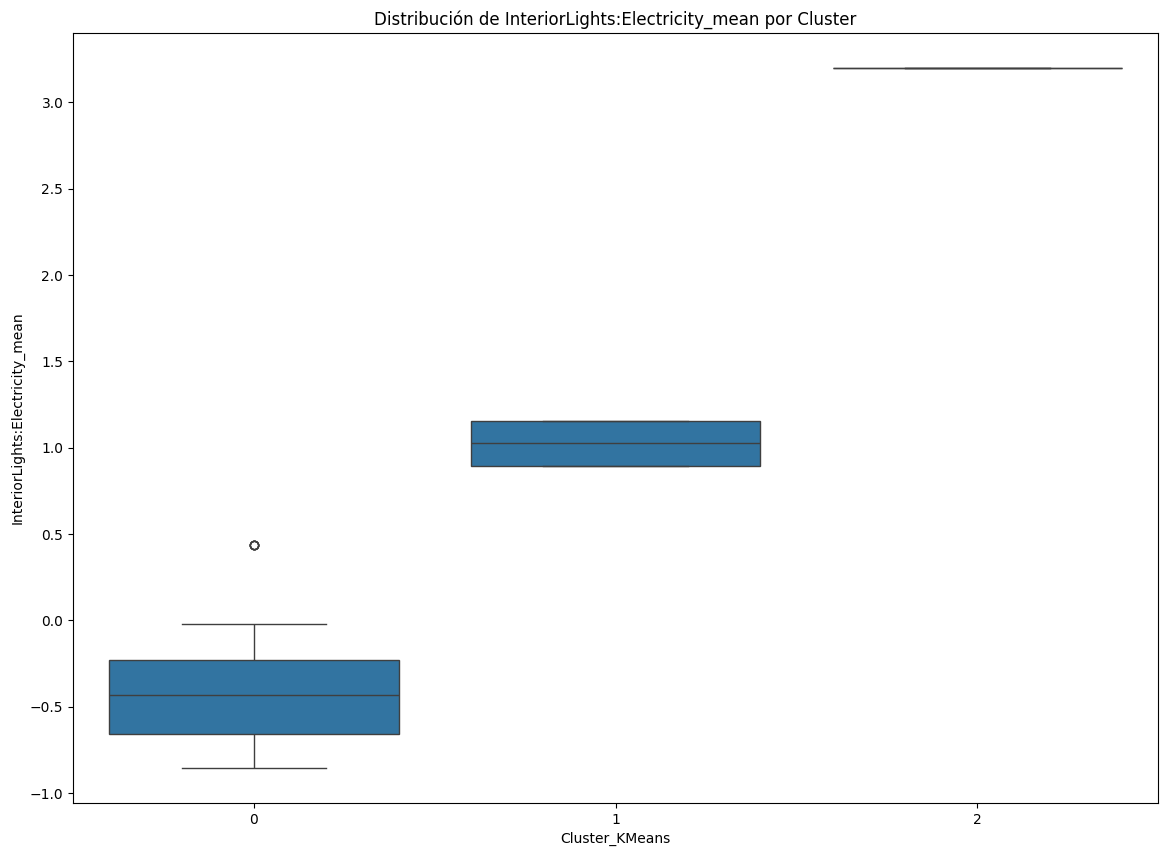

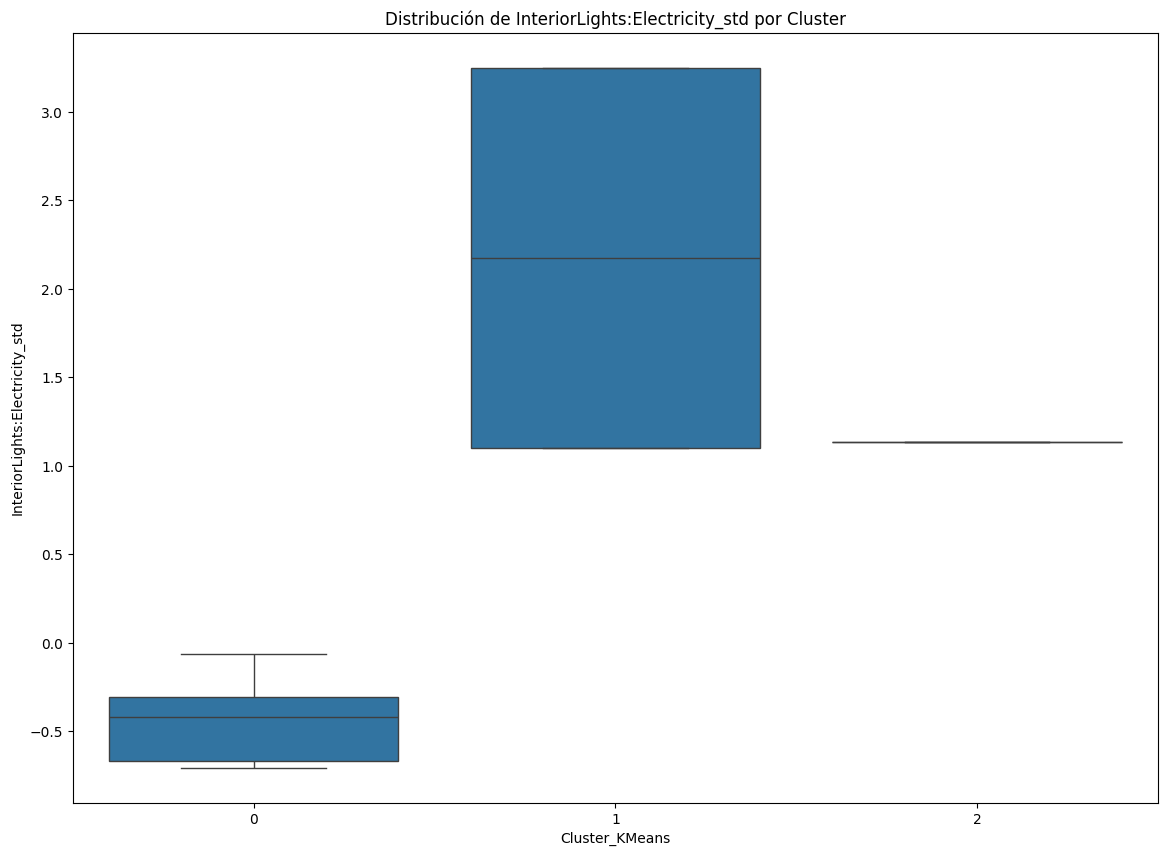

In [50]:
data_scaled_df = data_scaled_df.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

# Plotear los boxplots
for var in features.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_KMeans', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

## DBSCAN

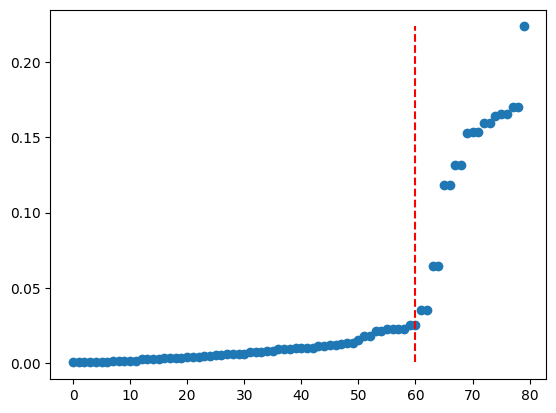

0.02554491422907347


In [33]:
#Calling our main function
idx, eps = get_eps(features.iloc[:, :6])

#Showing the rotated version used for find the elbow.
plt.show()

#Printing the exact values of our eps, from here we will round it
#and use it for our DBSCAN method.
print(eps)

In [34]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.025, min_samples=6)
clusters_dbscan = dbscan.fit_predict(features.iloc[:, :6])

# Agregar los clusters al DataFrame para análisis posterior
data_scaled_df['Cluster_DBSCAN'] = clusters_dbscan
# Mostrar los primeros registros con los clusters asignados por DBSCAN
data_scaled_df.head()

,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev,type_building,Cluster_KMeans,Cluster_DBSCAN
0,-0.520079,-0.635258,-0.553602,-0.610603,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1
1,-0.518781,-0.632764,-0.553802,-0.610796,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1
2,-0.518453,-0.628974,-0.553845,-0.610838,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1
3,-0.520768,-0.643505,-0.555026,-0.611981,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1
4,-0.520679,-0.643155,-0.554040,-0.611027,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [35]:
# Calcular el silhouette score para evaluar la calidad de los clusters, excluyendo los puntos ruidosos
if len(set(clusters_dbscan)) > 1:
    silhouette_dbscan = silhouette_score(features.iloc[:, :6], clusters_dbscan)
else:
    silhouette_dbscan = -1  # Silhouette score no es aplicable si hay un solo cluster
silhouette_dbscan

-1

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [36]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_dbscan= davies_bouldin_score(features.iloc[:, :6], clusters_dbscan)
davies_bouldin_dbscan

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

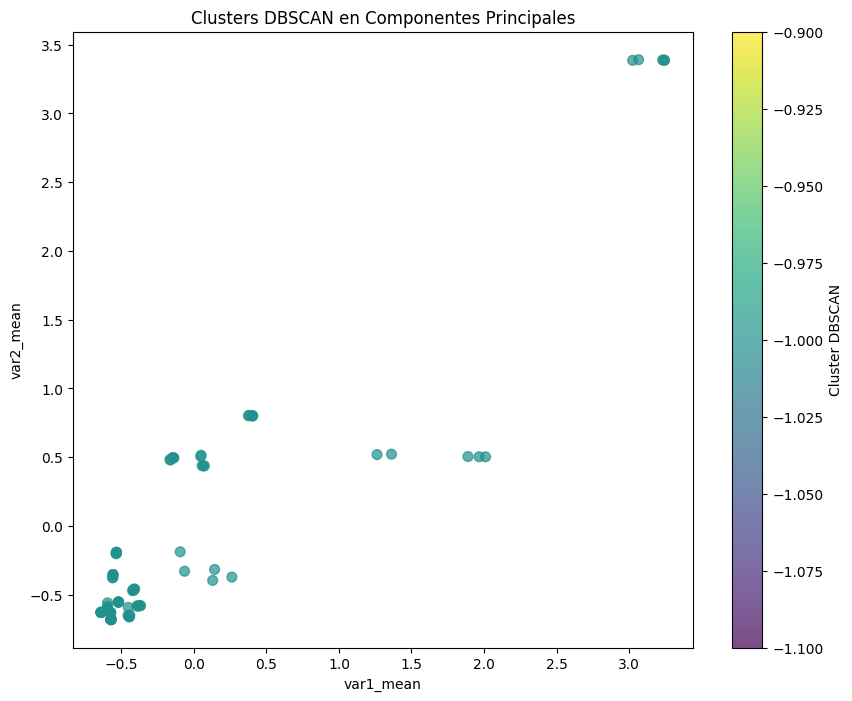

In [38]:
# Visualización de los clusters obtenidos por DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(data_scaled_df['var1_mean'], data_scaled_df['var2_mean'], c=data_scaled_df['Cluster_DBSCAN'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN en Componentes Principales')
plt.xlabel('var1_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster DBSCAN')
plt.show()

In [39]:
# Create crosstab: ct
ct = pd.crosstab(data_scaled_df['type_building'] ,data_scaled_df['Cluster_DBSCAN'] )
# Display ct
ct

Cluster_DBSCAN,-1
type_building,
RefBldgFullServiceRestaurantNew2004,5
RefBldgHospitalNew2004,5
RefBldgLargeHotelNew2004,5
RefBldgLargeOfficeNew2004,5
RefBldgMediumOfficeNew2004,5
RefBldgMidriseApartmentNew2004,5
RefBldgOutPatientNew2004,5
RefBldgPrimarySchoolNew2004,5
RefBldgQuickServiceRestaurantNew2004,5


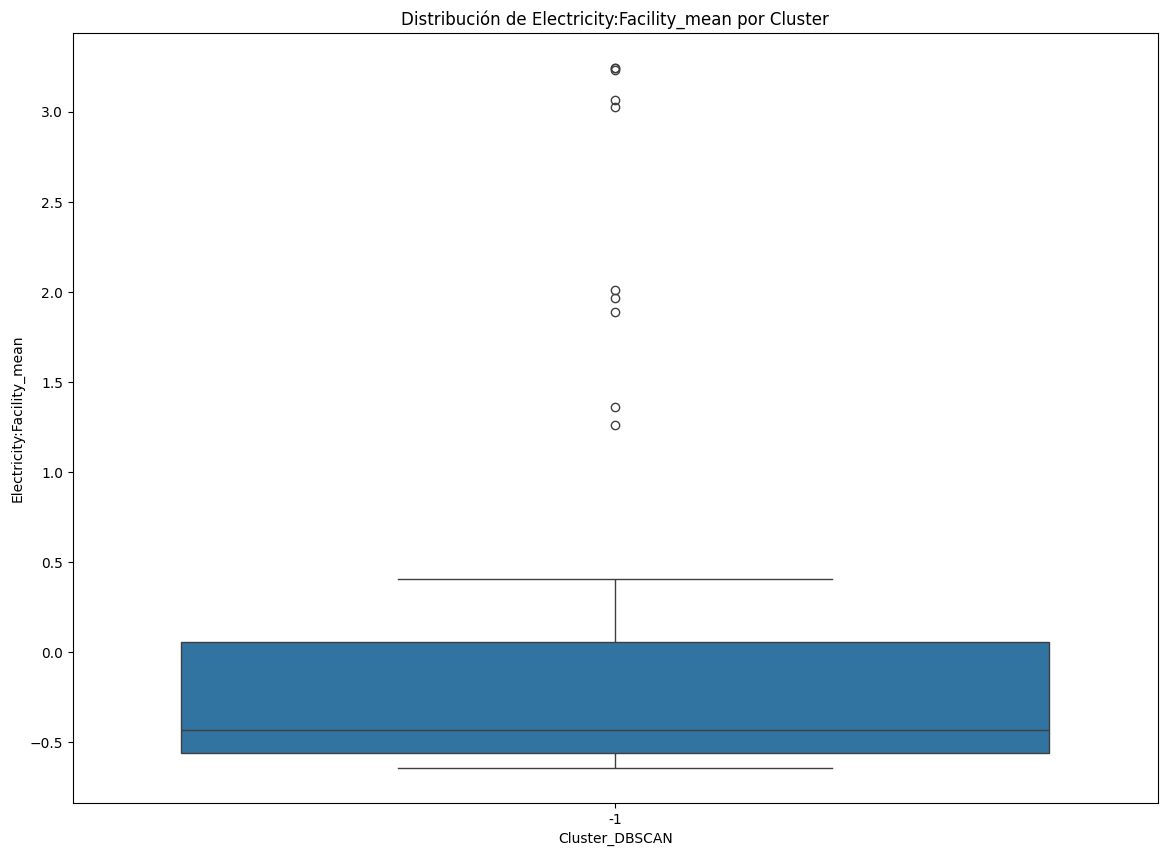

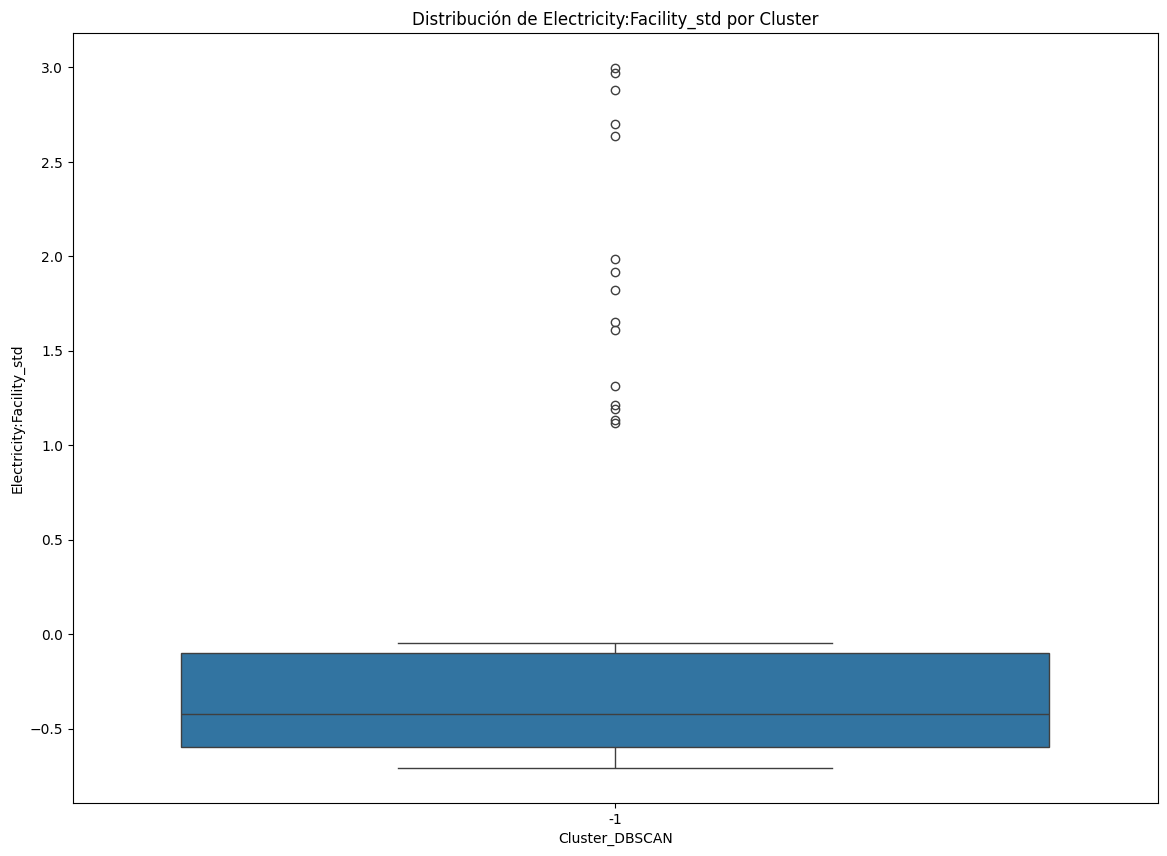

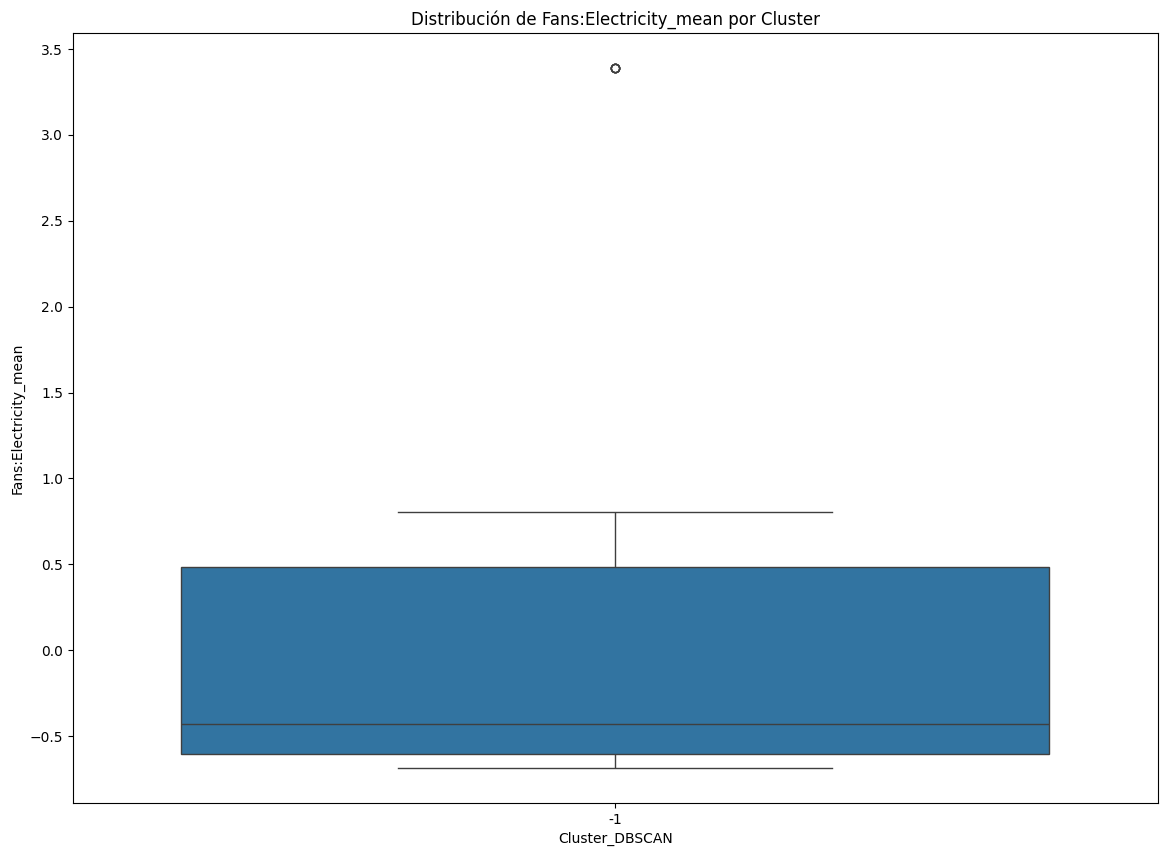

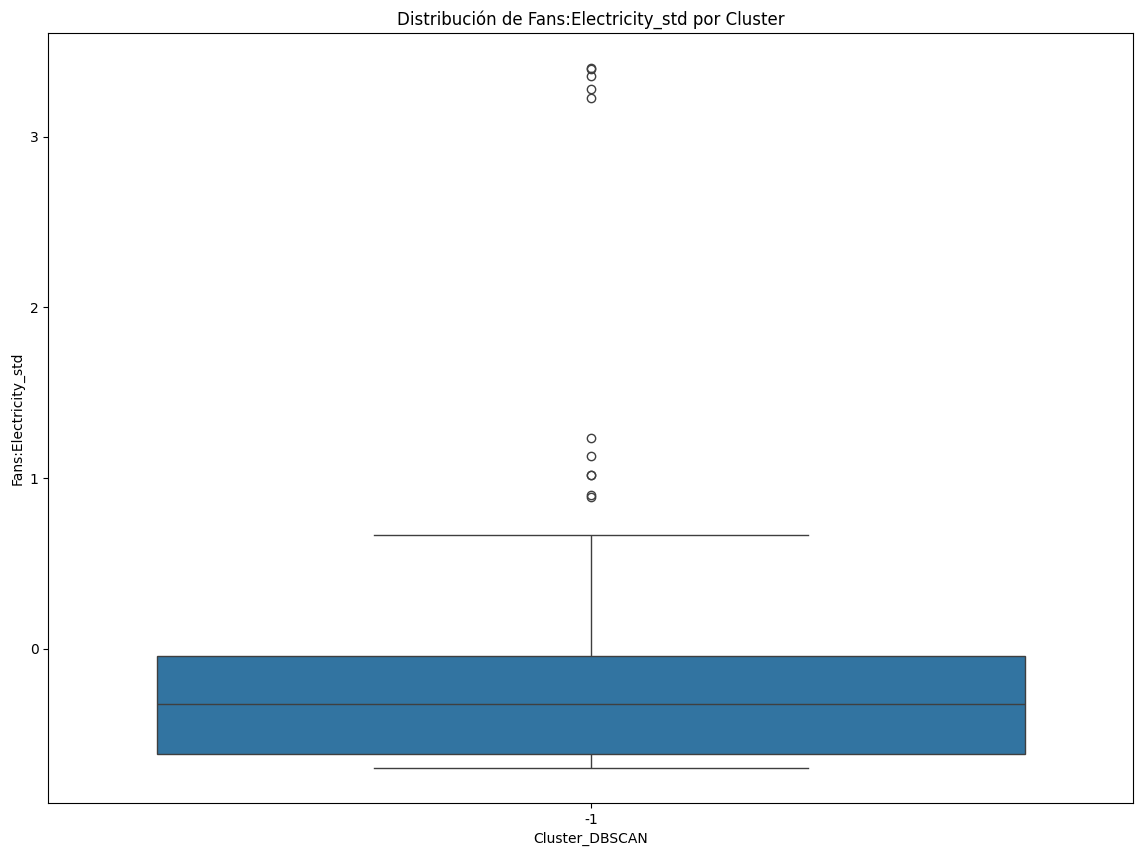

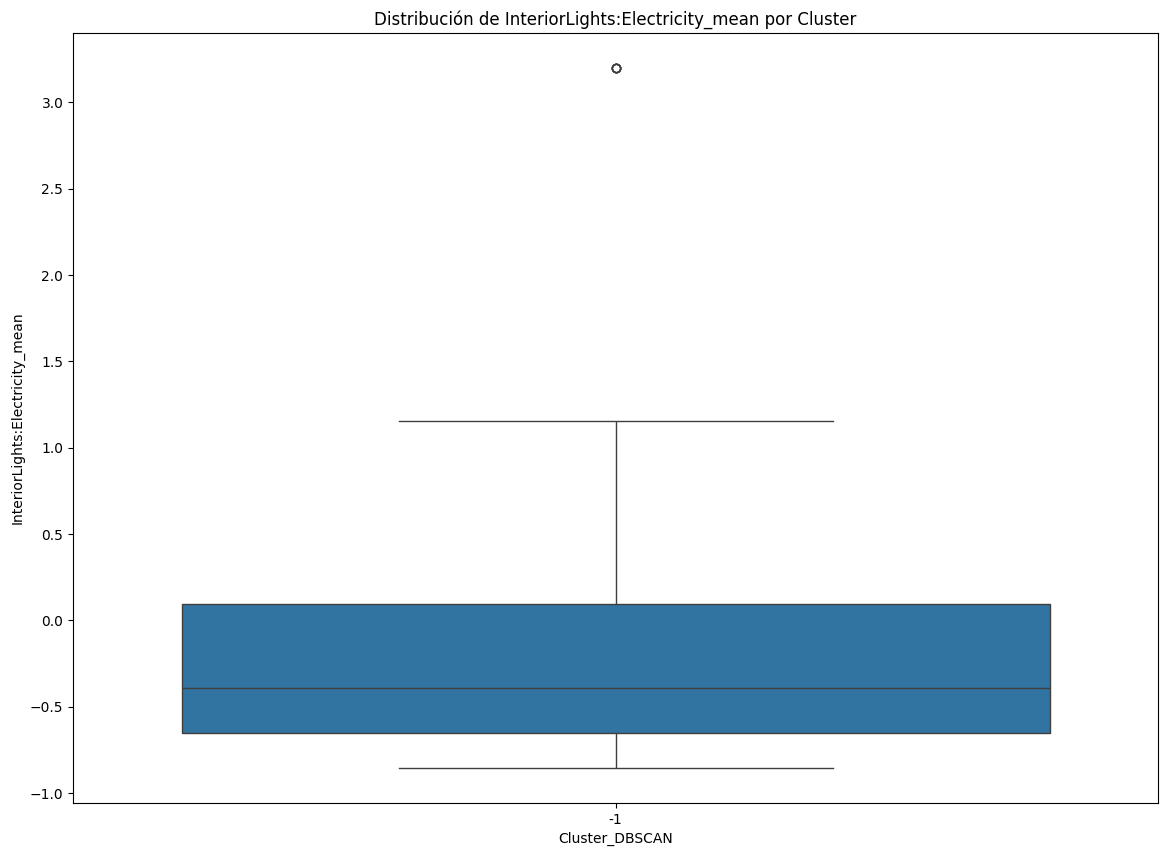

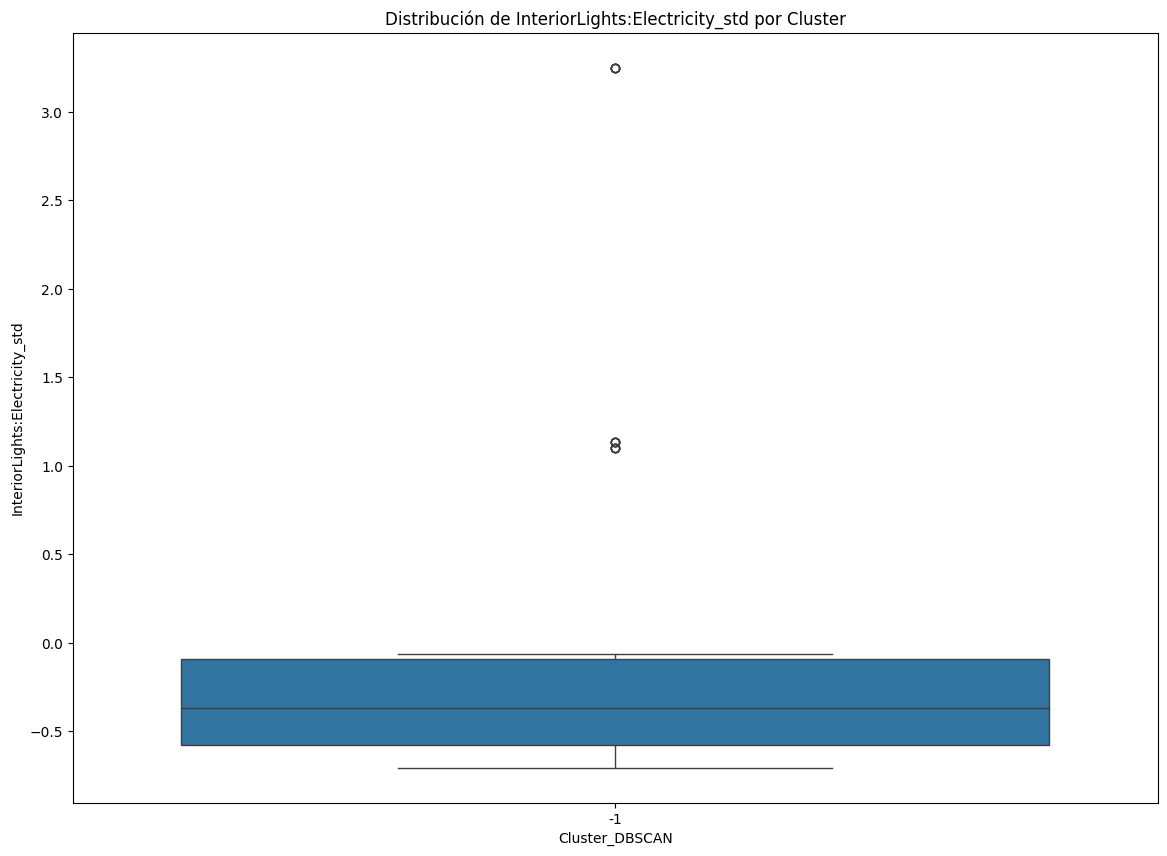

In [51]:
data_scaled_df = data_scaled_df.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

# Plotear los boxplots
for var in features.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_DBSCAN', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

## CLUSTERING HERARQUICO 

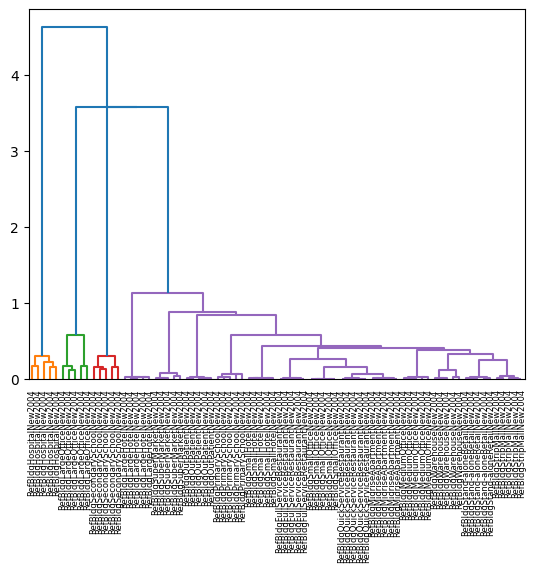

In [41]:
# Calculate the linkage: mergings
mergings = linkage(features.iloc[:, :6],method='single')

# Plot the dendrogram
dendrogram(mergings,labels= data_scaled_df['type_building'].tolist(),leaf_rotation=90,leaf_font_size=6)
plt.show()

In [42]:
# Calcular el linkage matrix
mergings = linkage(features.iloc[:, :6], method='single')

# Calcular las alturas de los clusters
last = mergings[-10:, 2]
last_rev = last[::-1]
indexes = np.arange(1, len(last) + 1)

# Calcular la aceleración
acceleration = np.diff(last, 2)  # Segunda derivada de las alturas
acceleration_rev = acceleration[::-1]

# Encontrar el número óptimo de clusters
k = acceleration_rev.argmax() + 2  # +2 porque la primera derivada se pierde y Python indexa desde 0

print(f'El número óptimo de clusters es: {k}')

El número óptimo de clusters es: 4


In [43]:
# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=4)
clusters_hierarchical = hierarchical.fit_predict(features.iloc[:, :6])

# Agregar los clusters al DataFrame para análisis posterior
data_scaled_df['Cluster_Hierarchical'] = clusters_hierarchical
# Mostrar los primeros registros con los clusters asignados por Clustering Jerárquico
data_scaled_df.head()

,var1_mean,var1_std_dev,var2_mean,var2_std_dev,var3_mean,var3_std_dev,type_building,Cluster_KMeans,Cluster_DBSCAN,Cluster_Hierarchical
0,-0.520079,-0.635258,-0.553602,-0.610603,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1,0
1,-0.518781,-0.632764,-0.553802,-0.610796,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1,0
2,-0.518453,-0.628974,-0.553845,-0.610838,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1,0
3,-0.520768,-0.643505,-0.555026,-0.611981,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1,0
4,-0.520679,-0.643155,-0.554040,-0.611027,-0.50177,-0.665124,RefBldgFullServiceRestaurantNew2004,0,-1,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [44]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_hierarchical = silhouette_score(features.iloc[:, :6], clusters_hierarchical)
silhouette_hierarchical

0.8126855689241911

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [45]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_hierarchical= davies_bouldin_score(features.iloc[:, :6], clusters_hierarchical)
davies_bouldin_hierarchical

0.1788615761848399

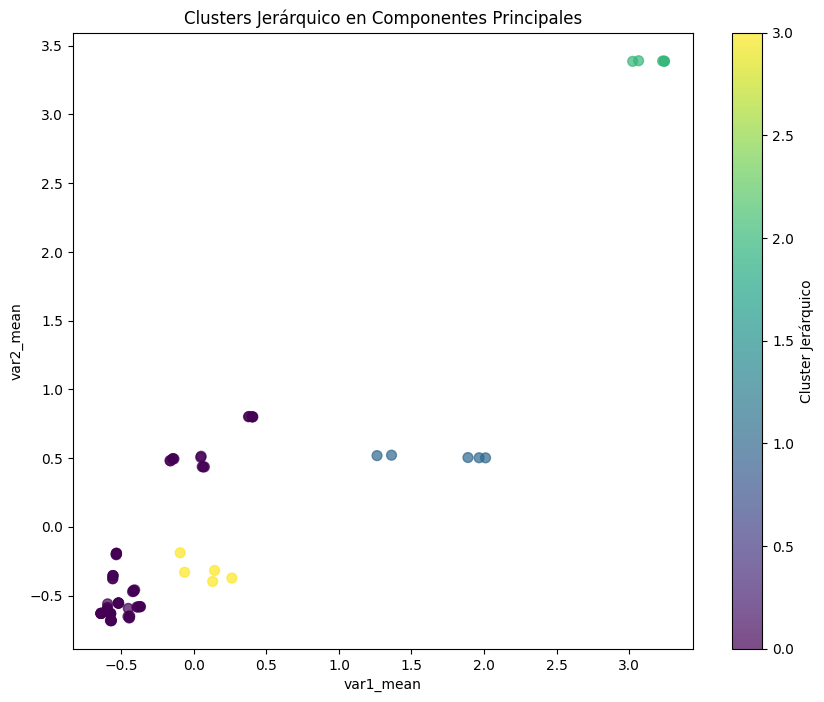

In [46]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(data_scaled_df["var1_mean"], data_scaled_df['var2_mean'], c=data_scaled_df['Cluster_Hierarchical'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('var1_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster Jerárquico')
plt.show()

In [47]:
# Create crosstab: ct
ct = pd.crosstab(data_scaled_df['type_building'] ,data_scaled_df['Cluster_Hierarchical'] )
# Display ct
ct

Cluster_Hierarchical,0,1,2,3
type_building,,,,
RefBldgFullServiceRestaurantNew2004,5,0,0,0
RefBldgHospitalNew2004,0,0,5,0
RefBldgLargeHotelNew2004,5,0,0,0
RefBldgLargeOfficeNew2004,0,5,0,0
RefBldgMediumOfficeNew2004,5,0,0,0
RefBldgMidriseApartmentNew2004,5,0,0,0
RefBldgOutPatientNew2004,5,0,0,0
RefBldgPrimarySchoolNew2004,5,0,0,0
RefBldgQuickServiceRestaurantNew2004,5,0,0,0


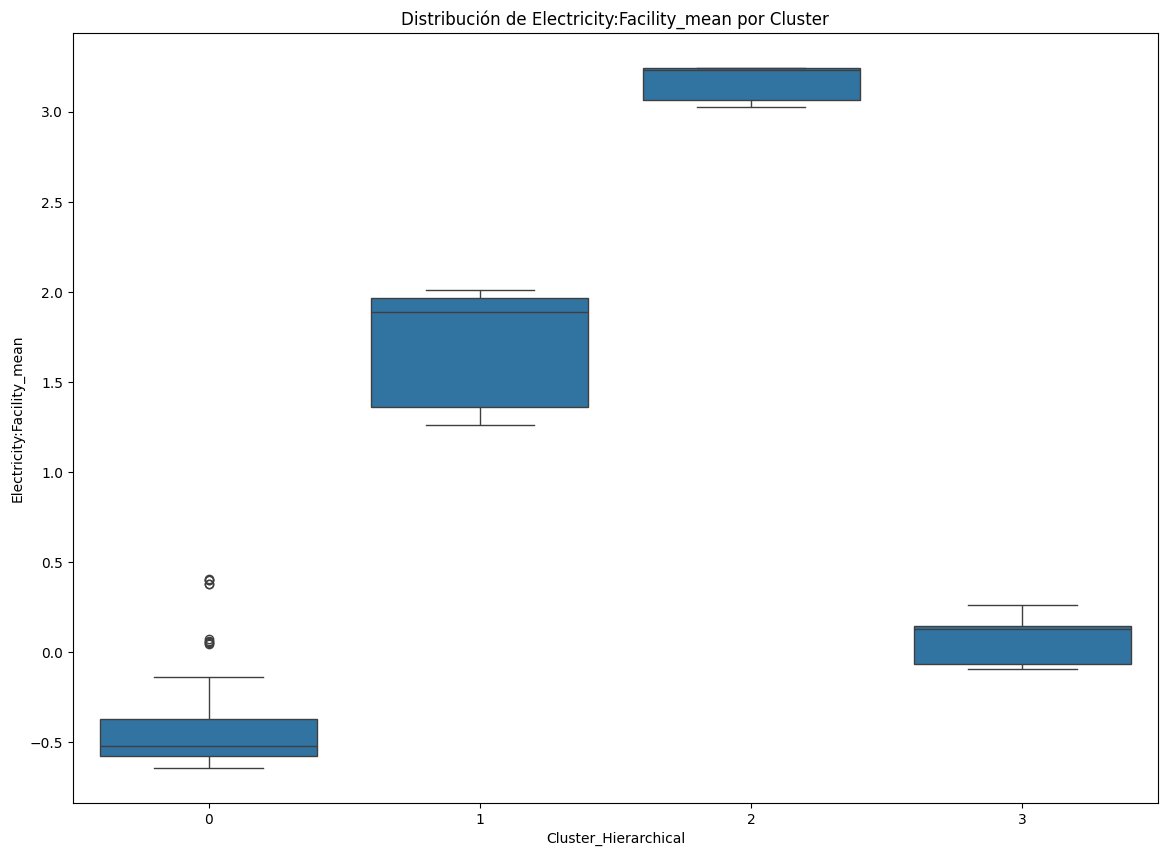

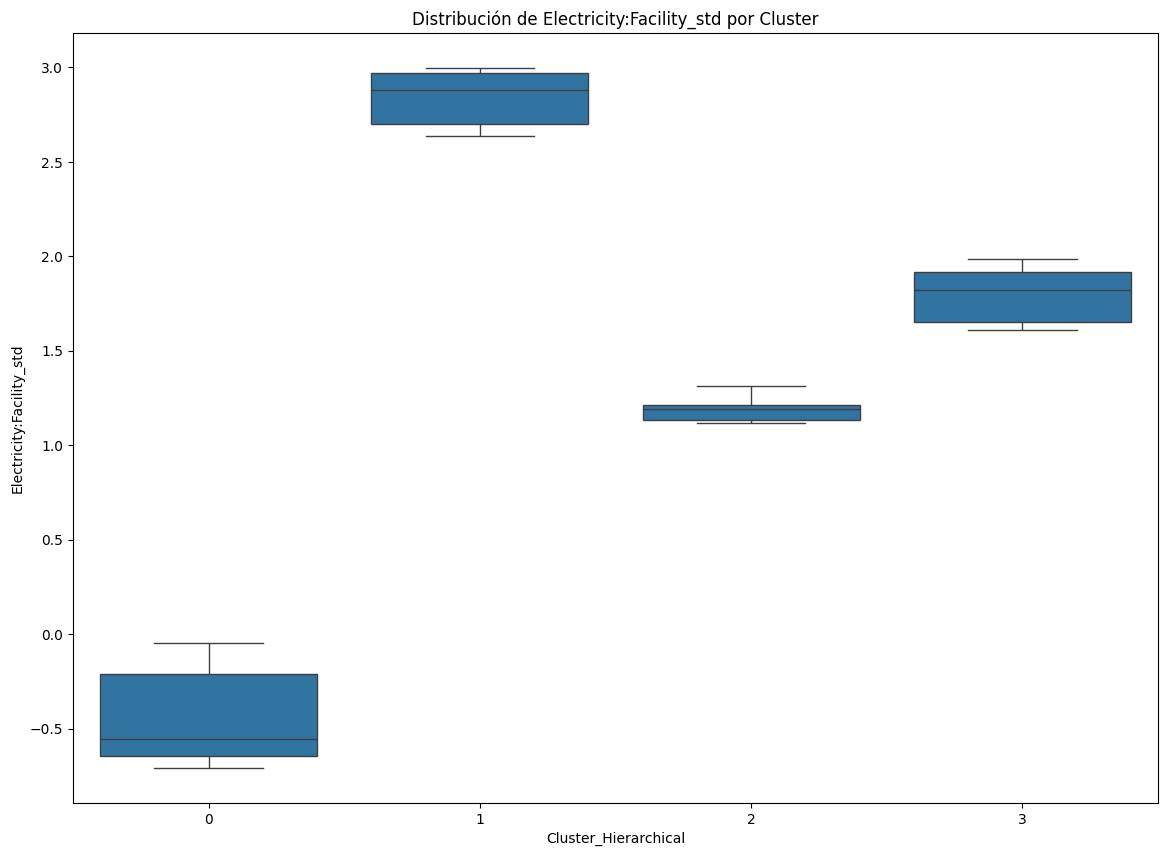

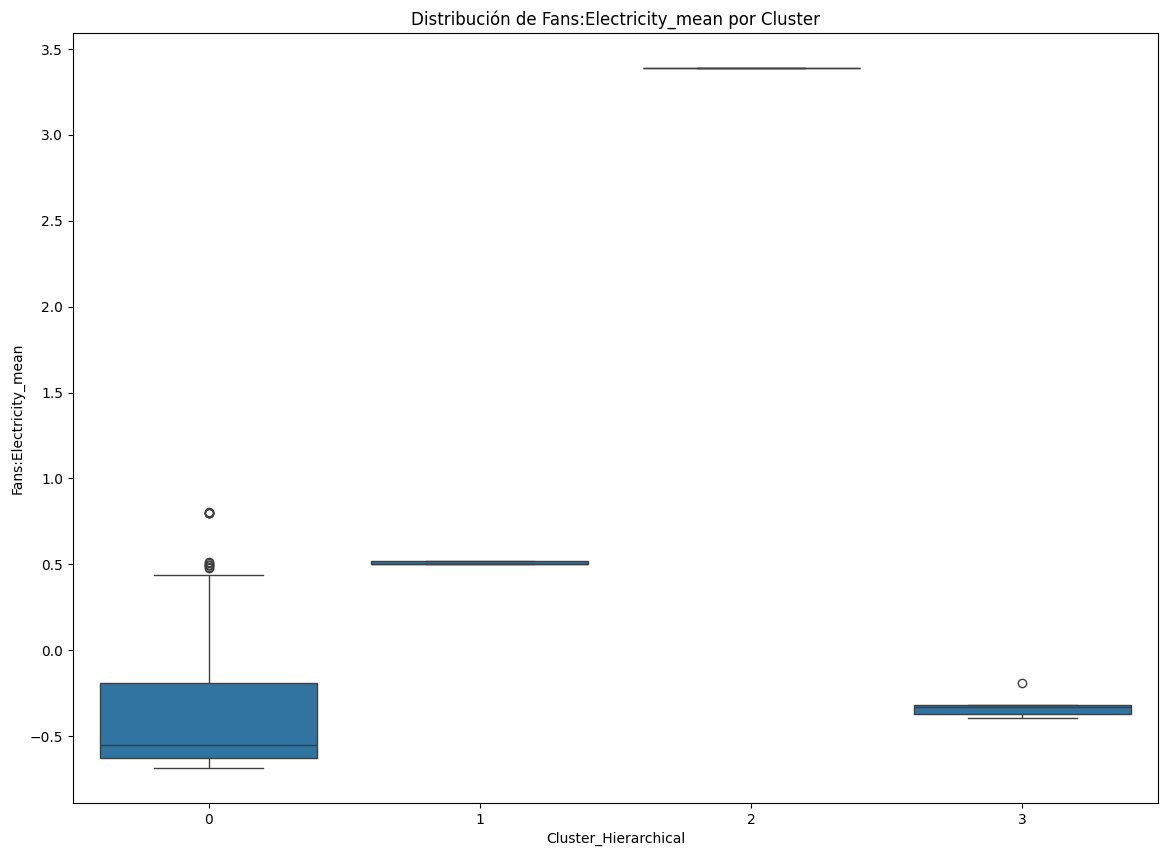

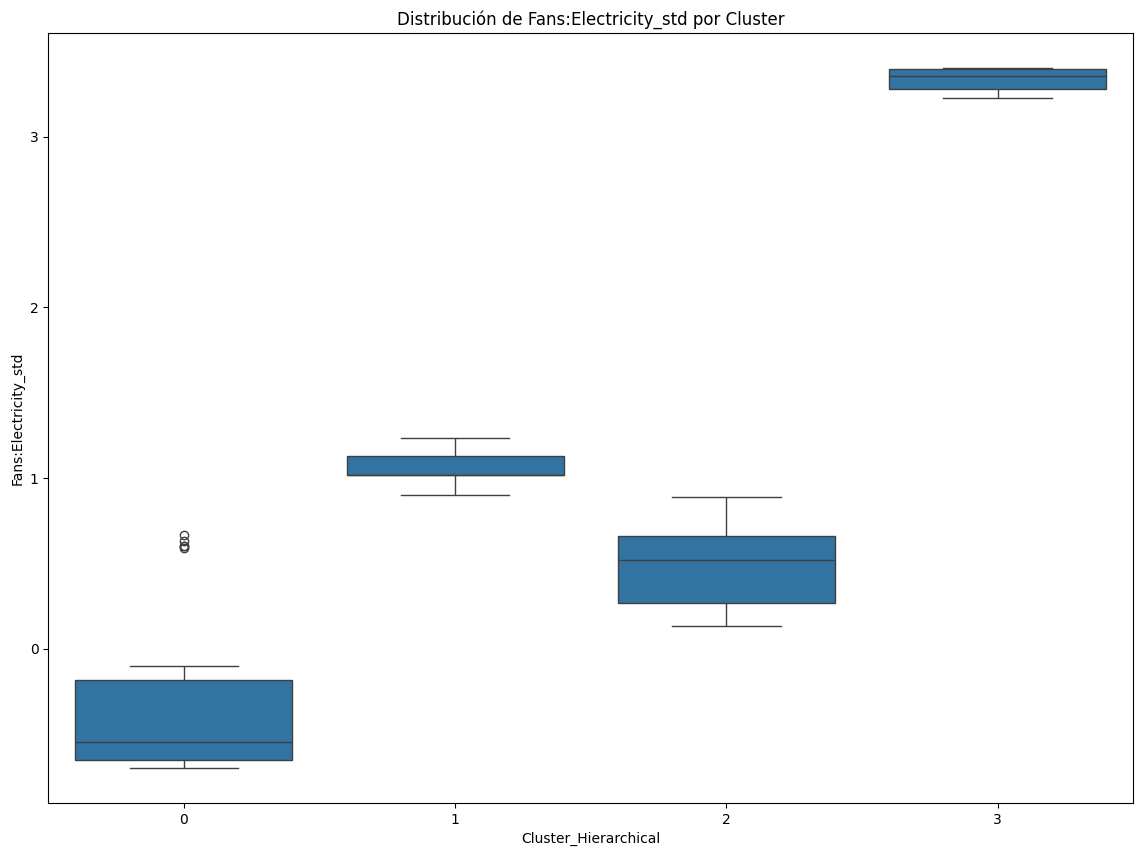

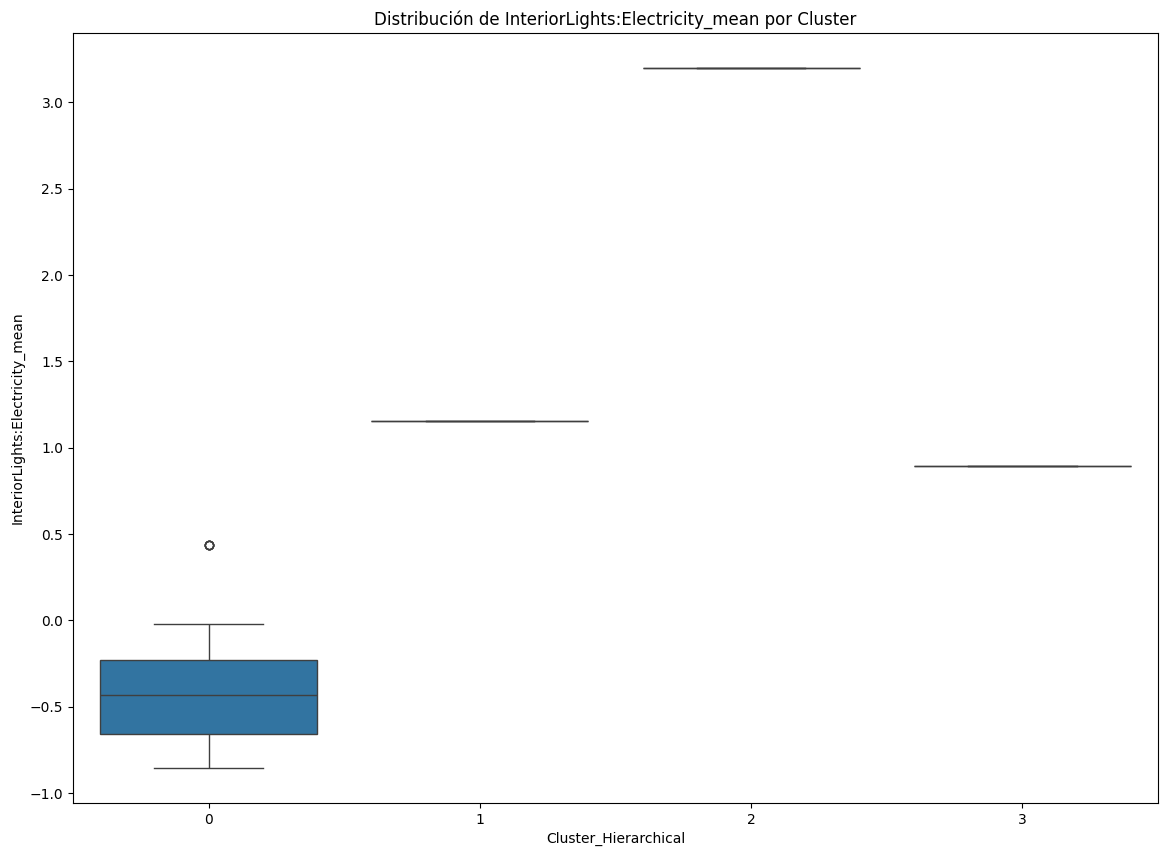

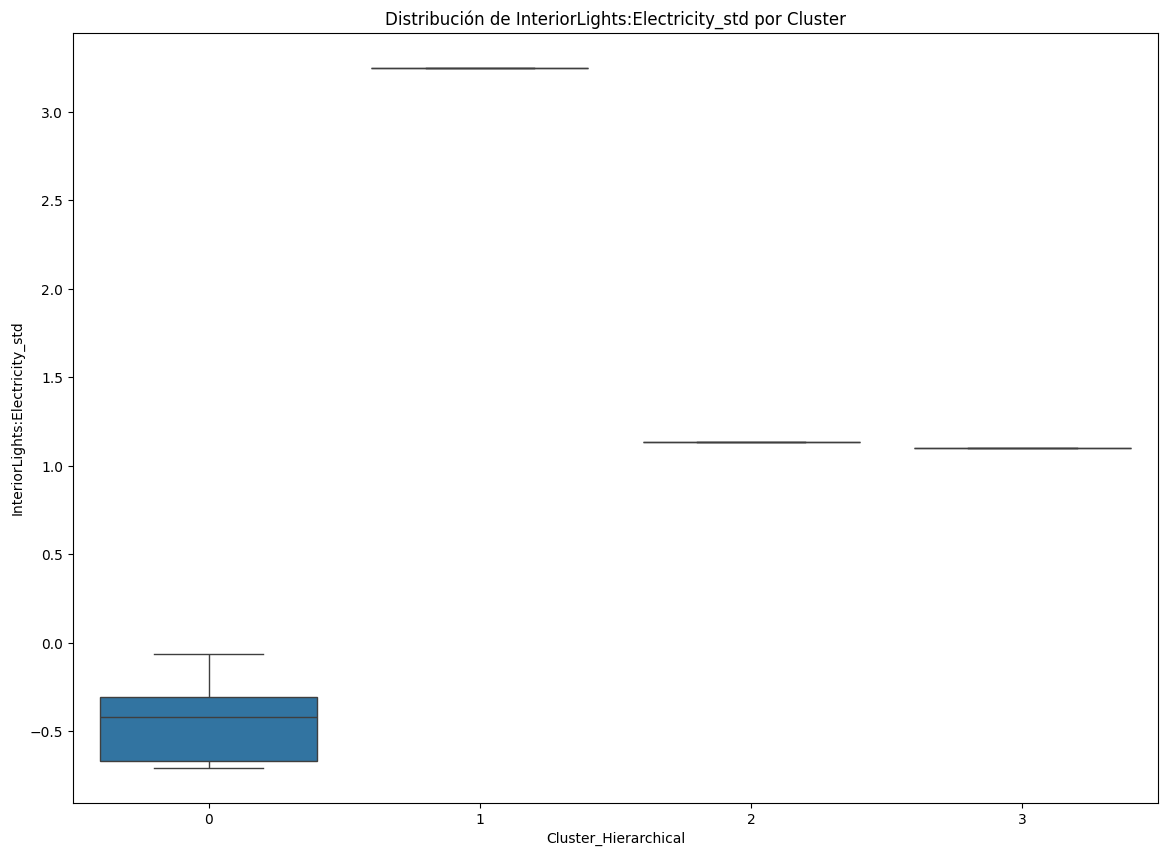

In [49]:
data_scaled_df = data_scaled_df.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

# Plotear los boxplots
for var in features.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_Hierarchical', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()